In [12]:
import pandas as pd
import numpy as np
import sklearn.metrics as sm
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
data = pd.read_csv('../dataset/data_cleaned.csv')

Taux d'erreur: 16.65%


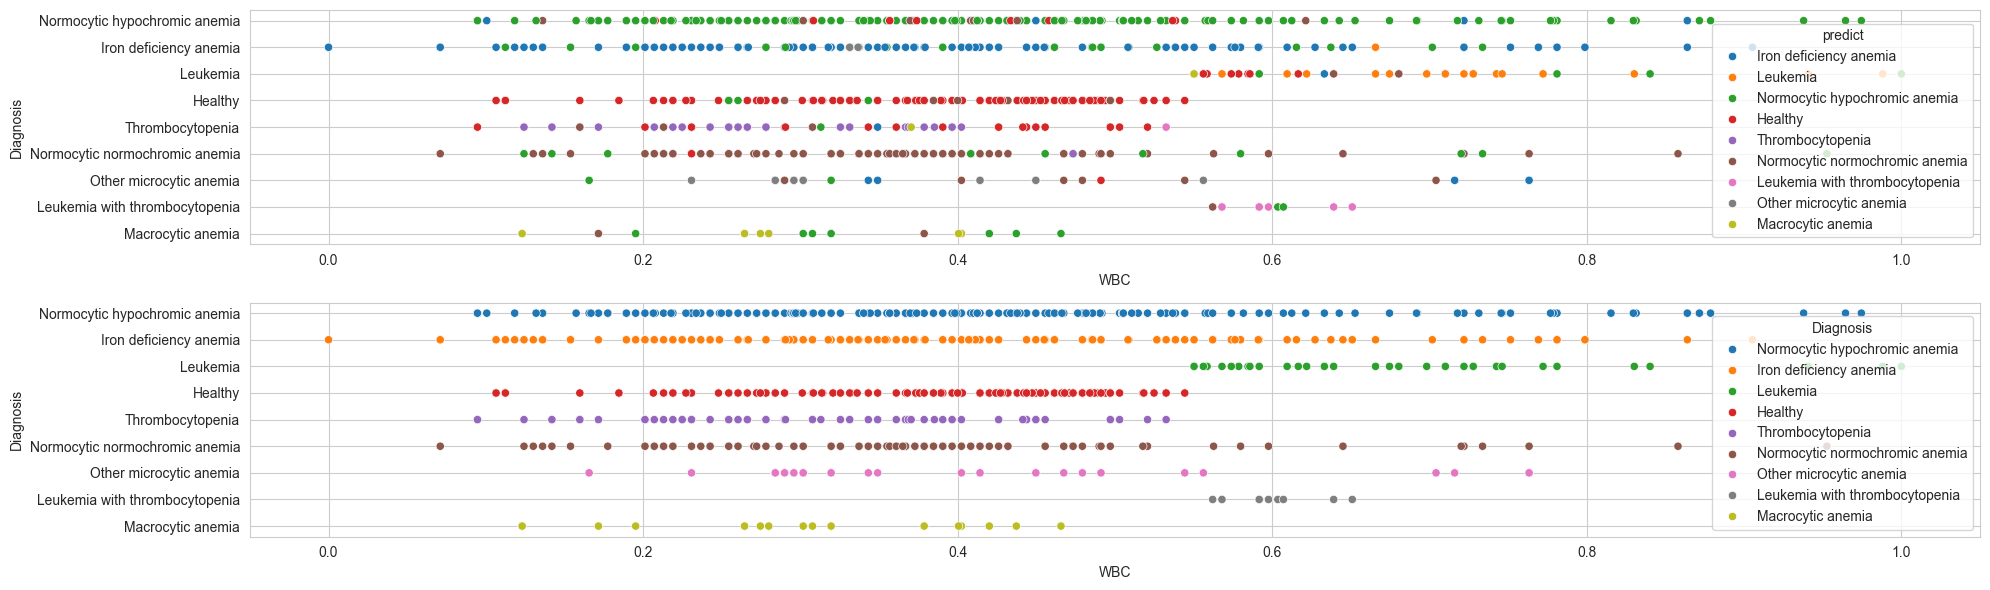

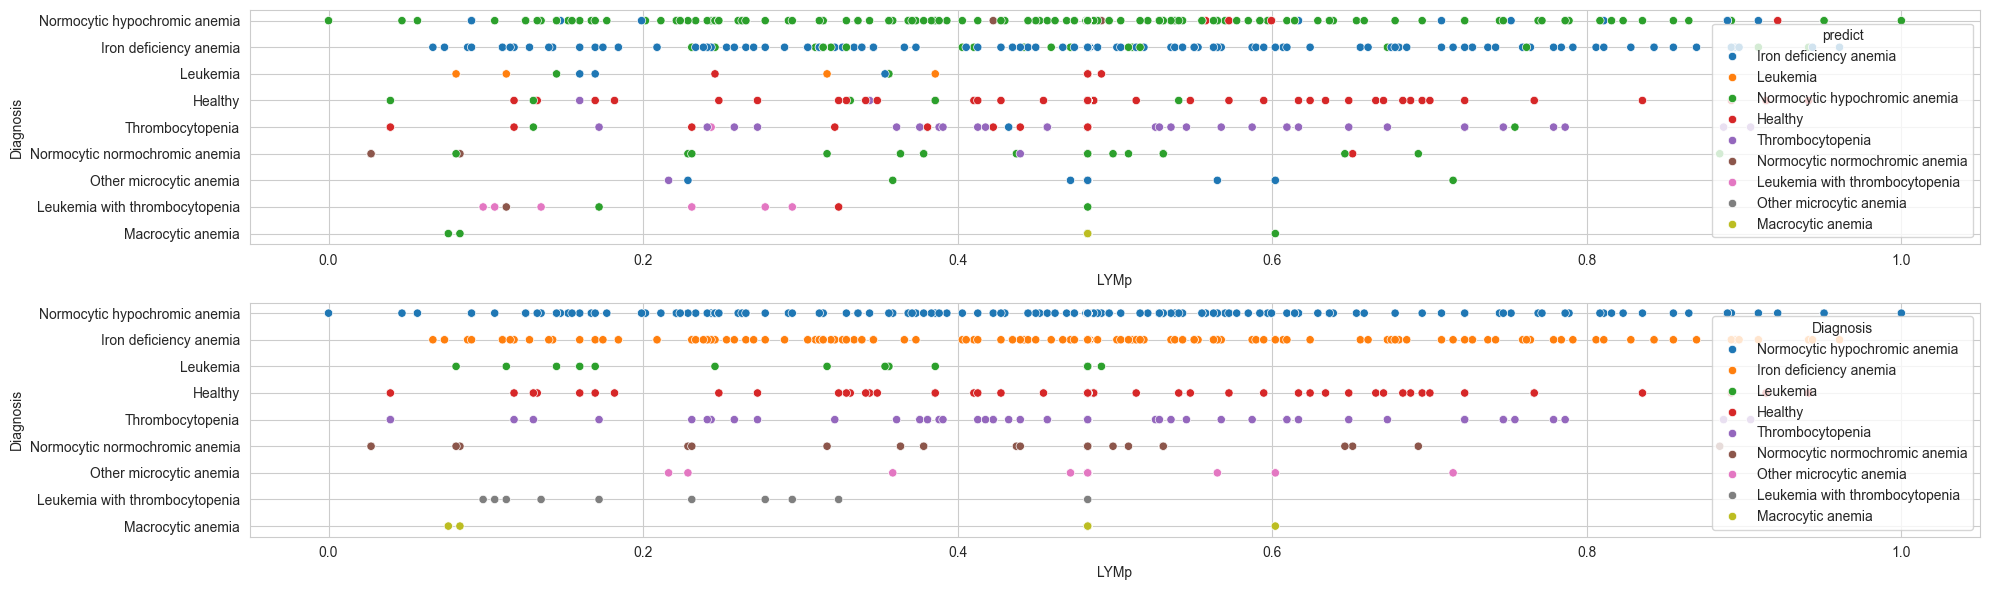

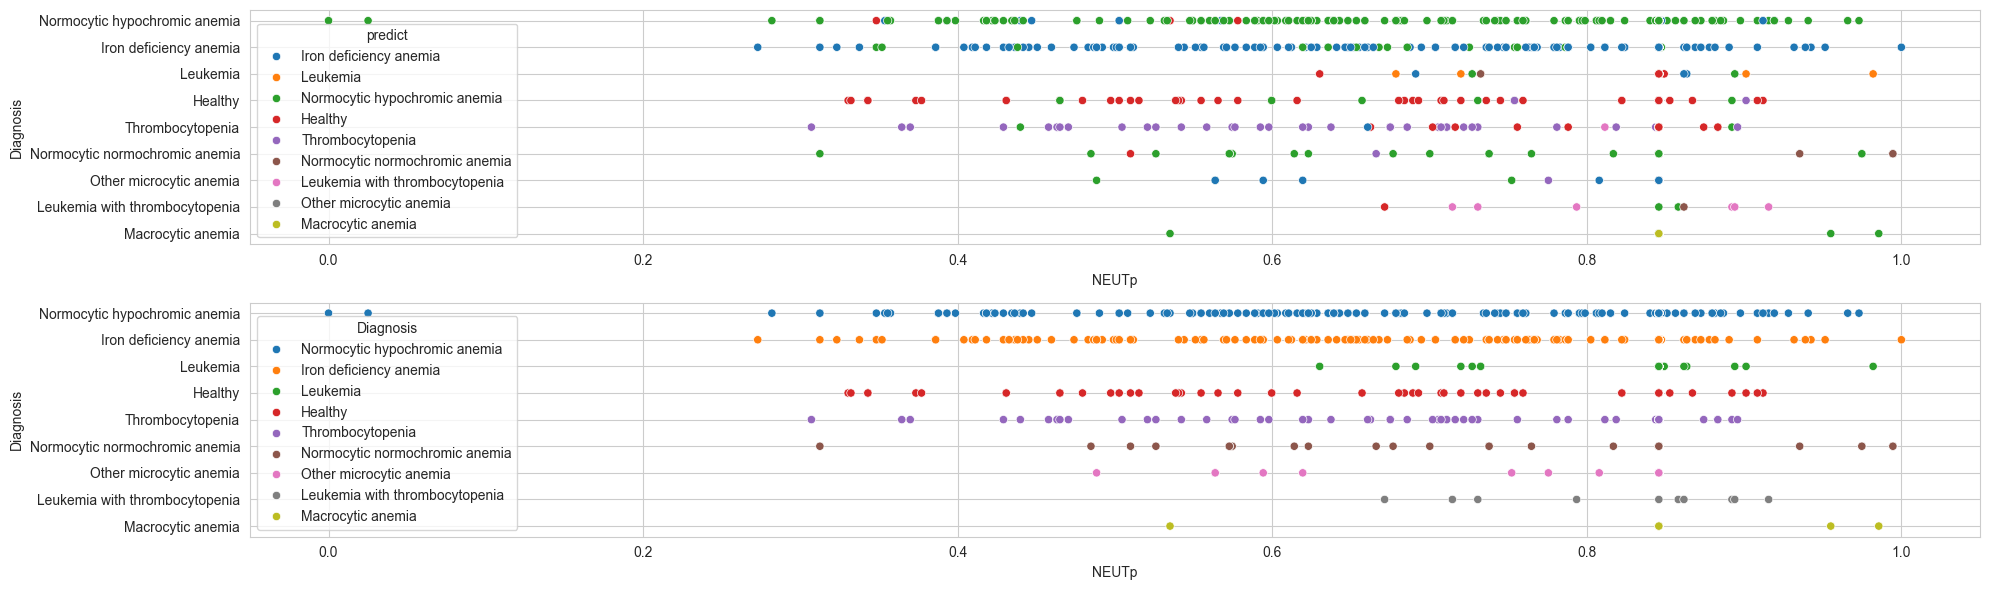

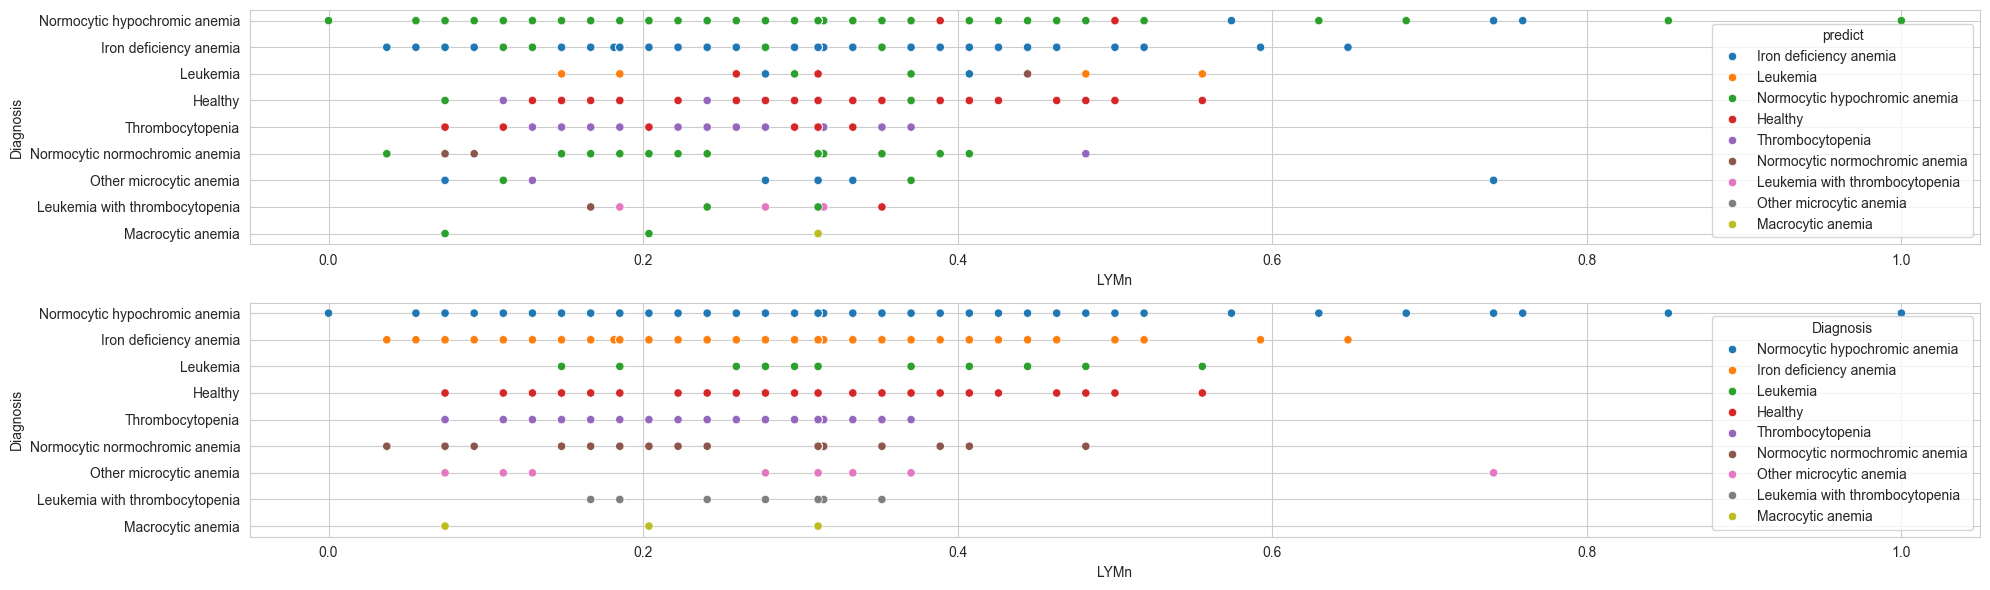

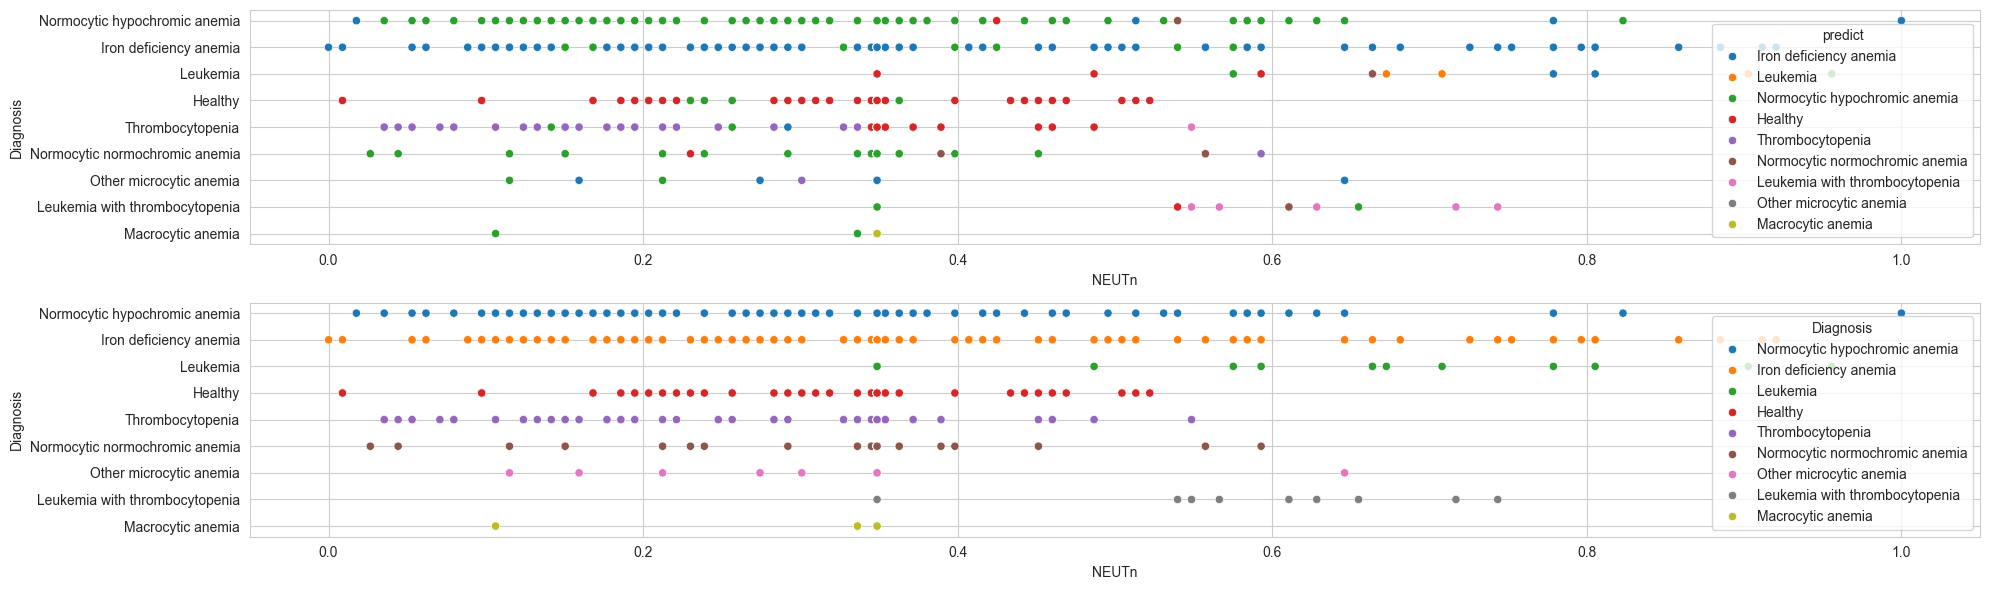

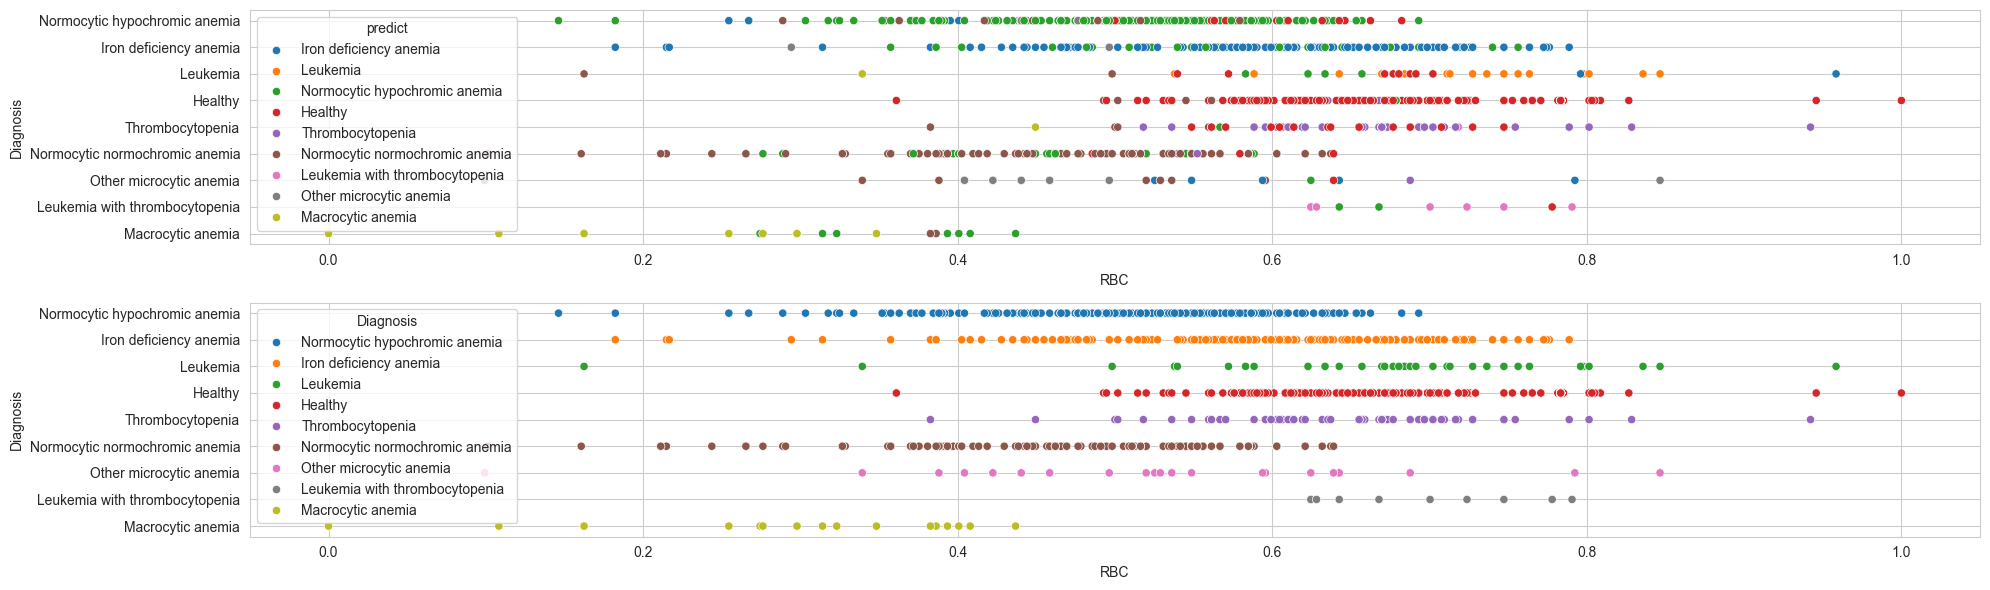

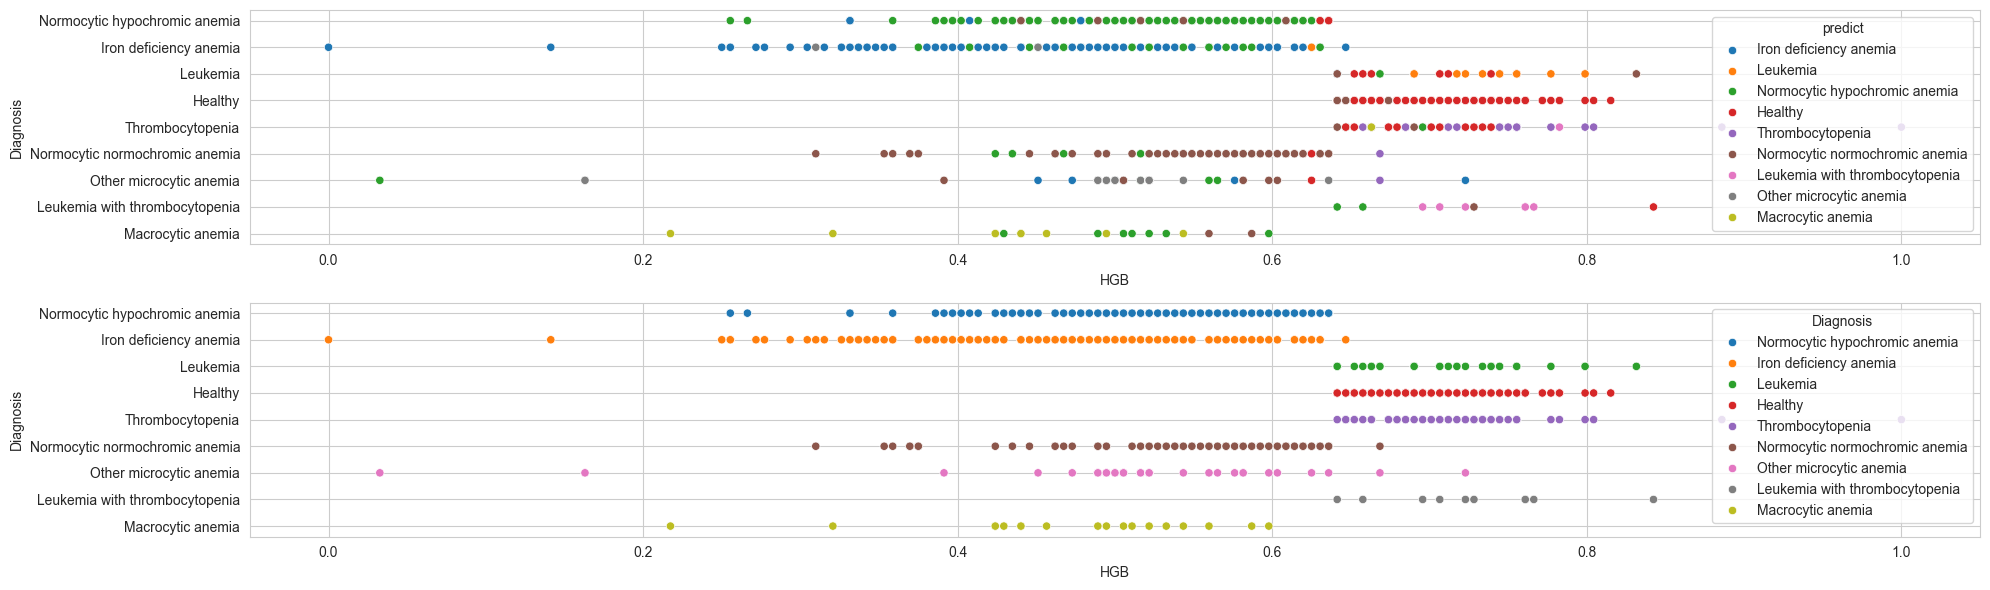

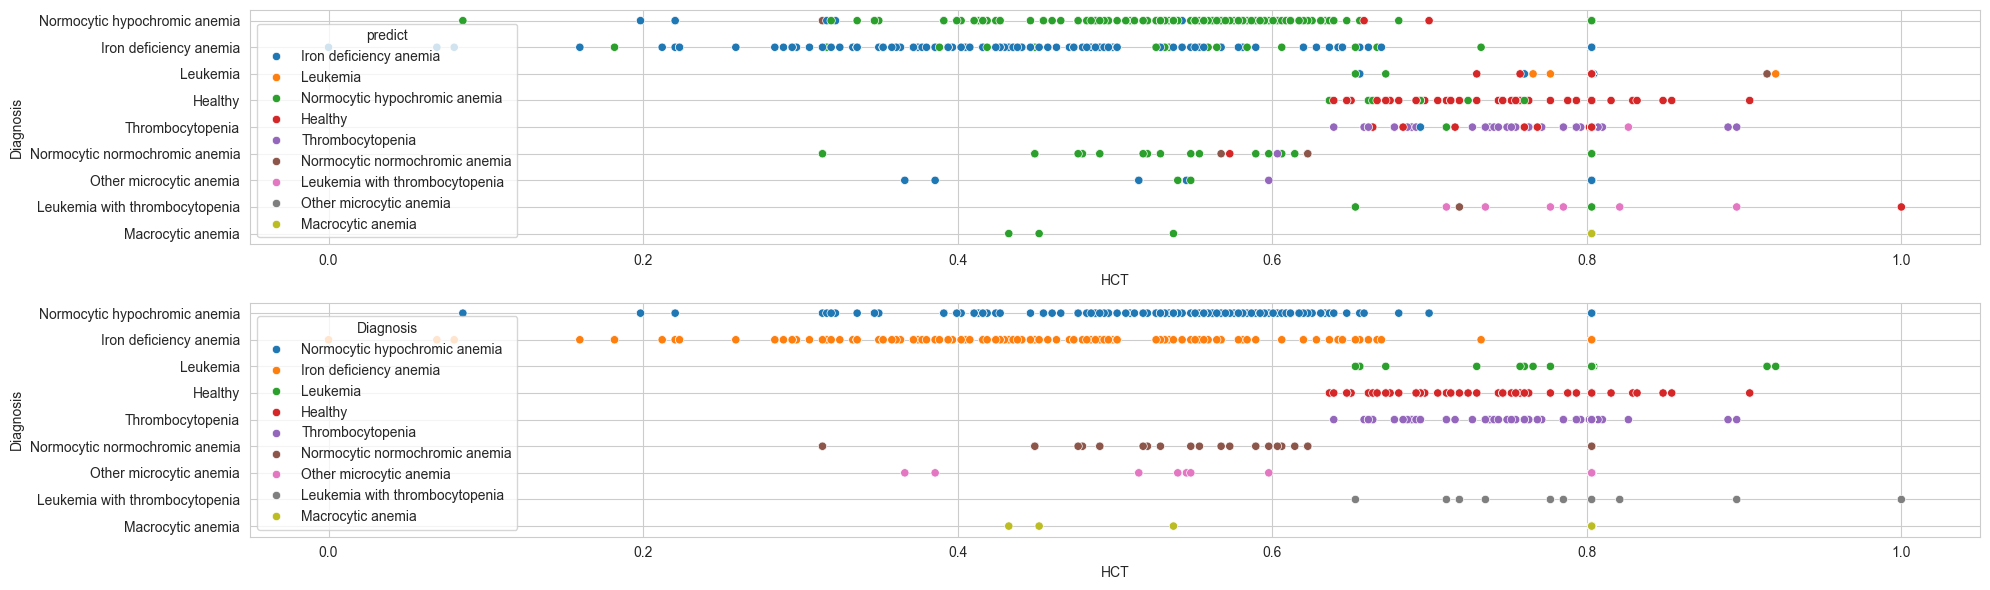

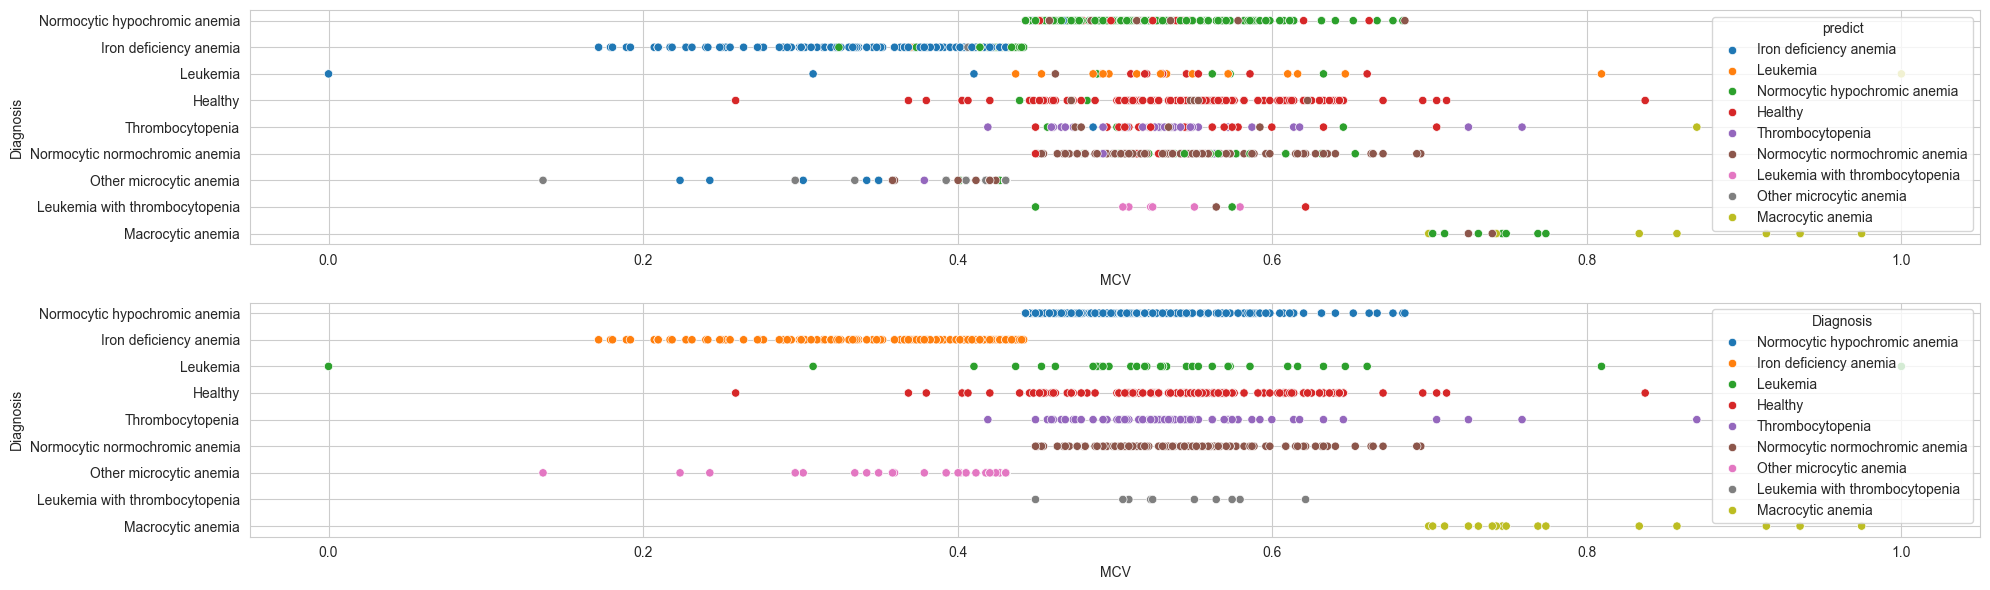

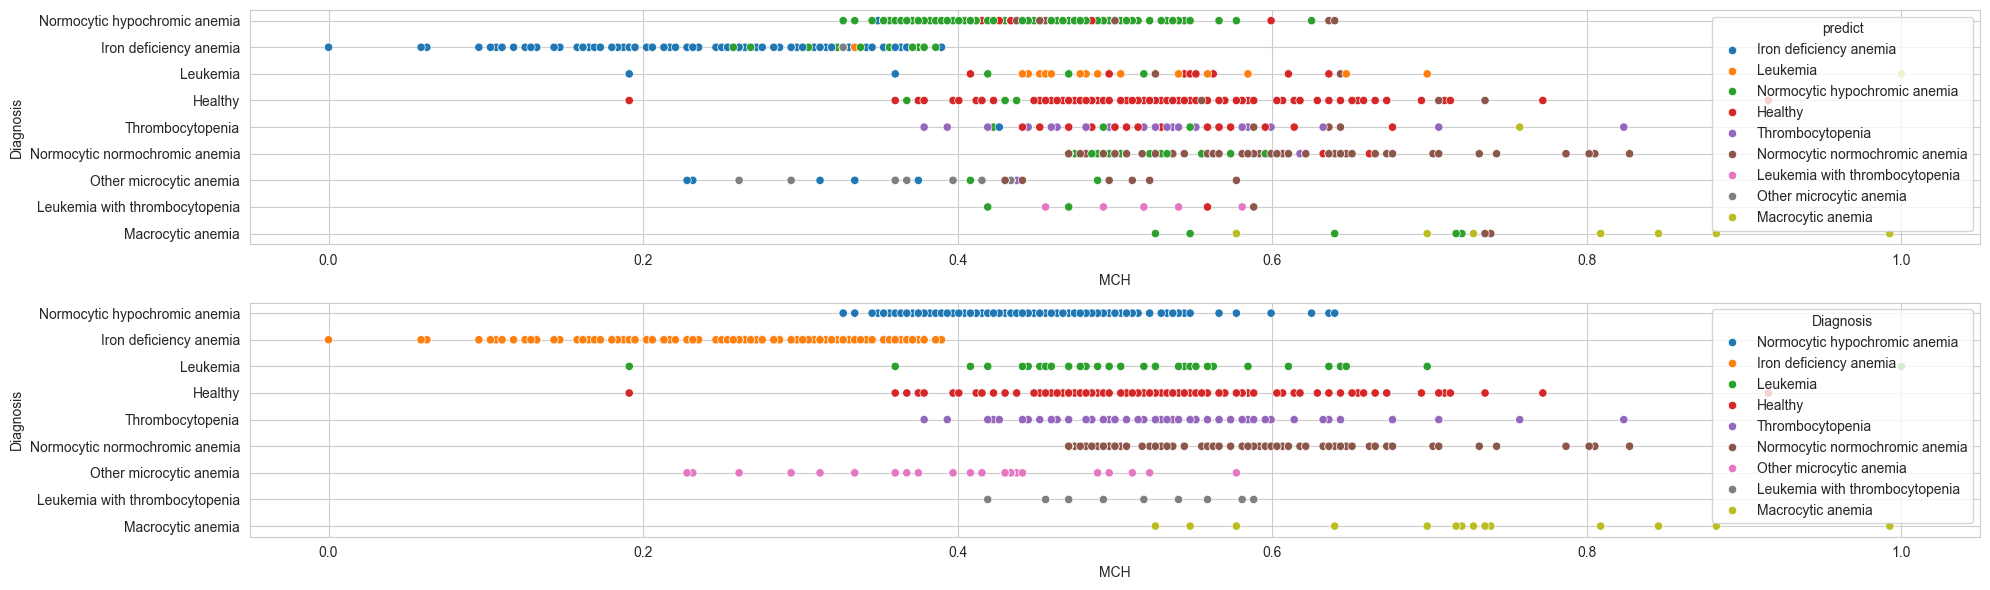

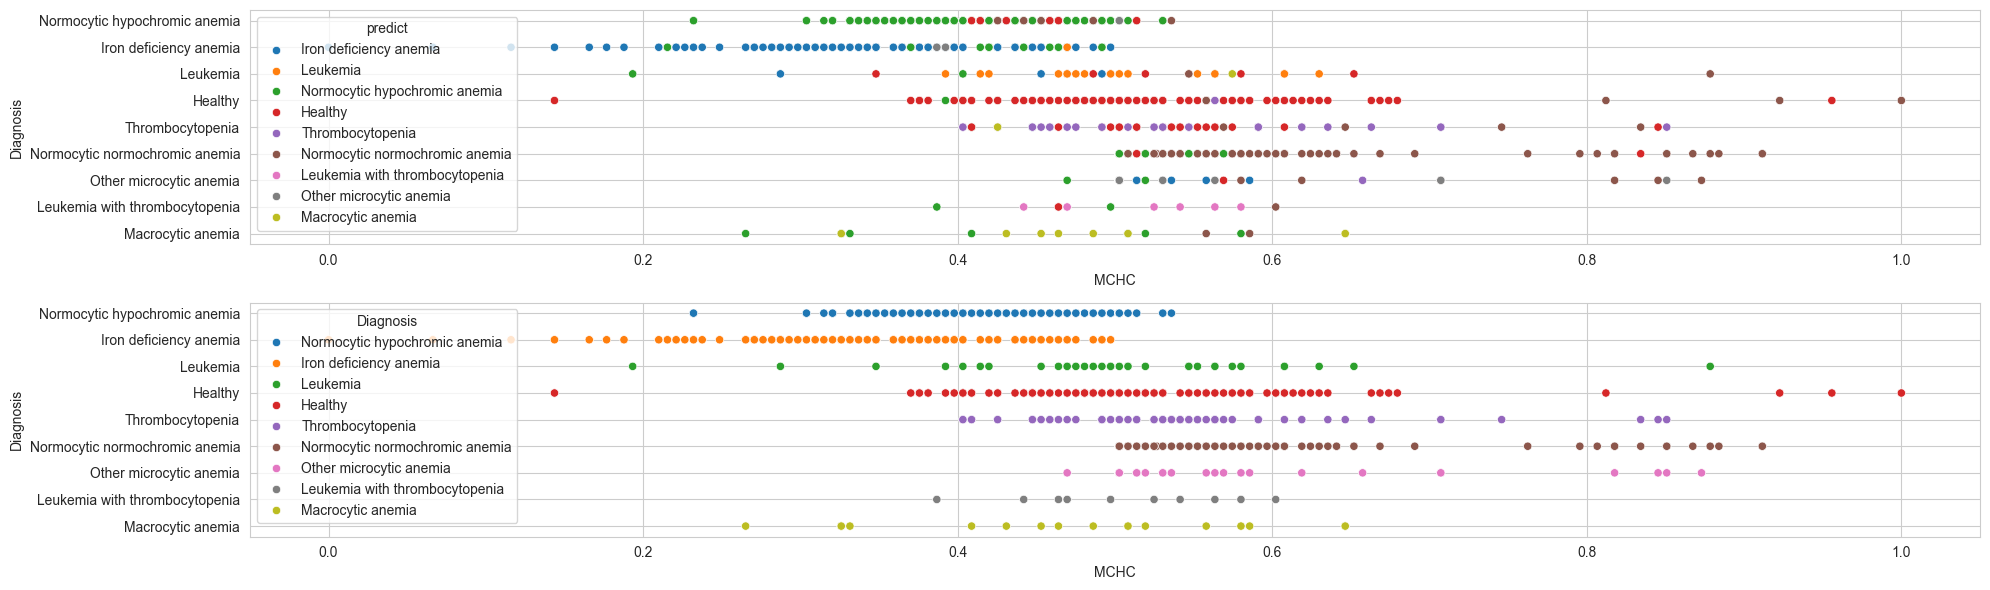

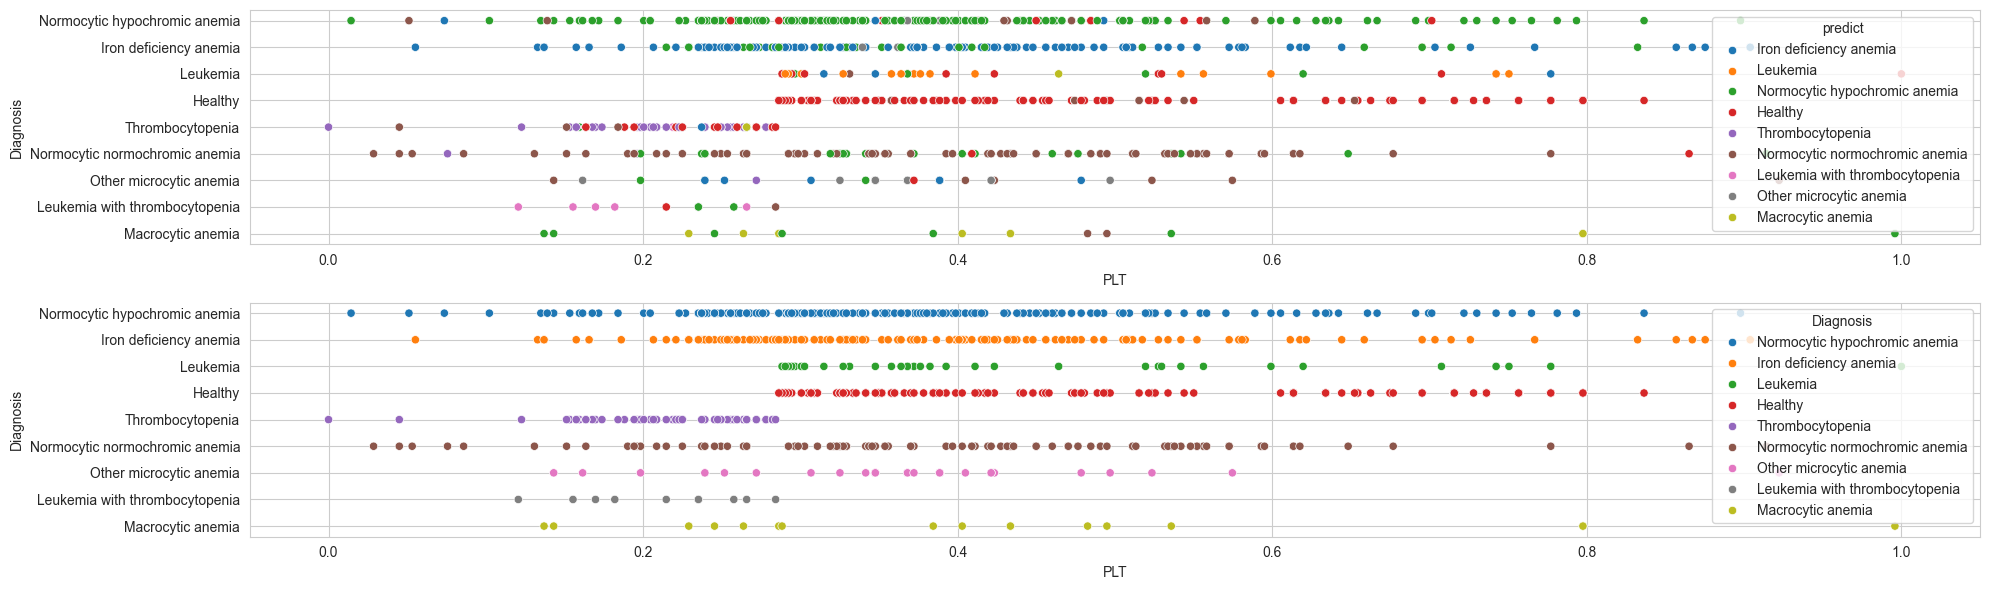

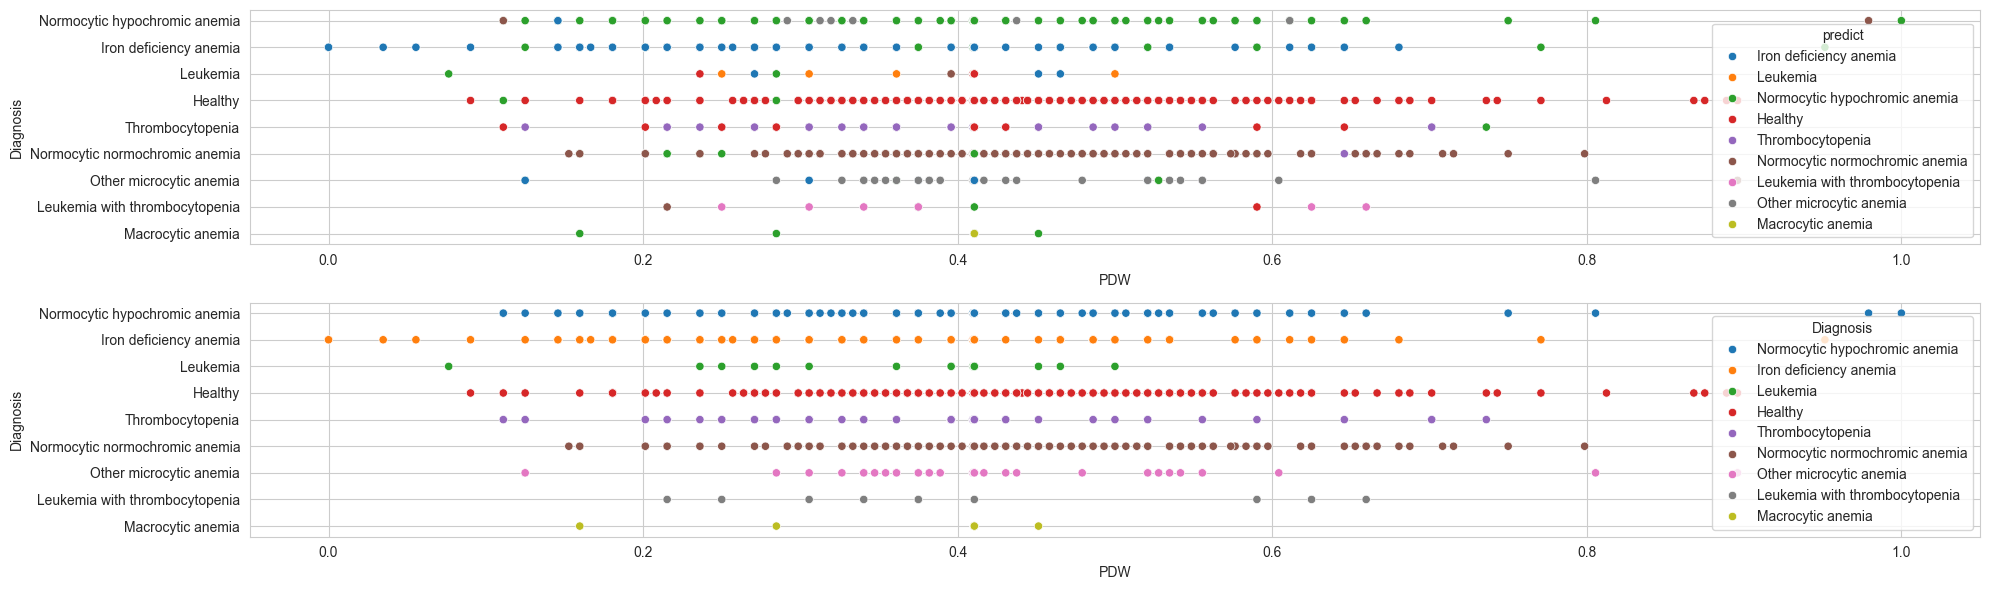

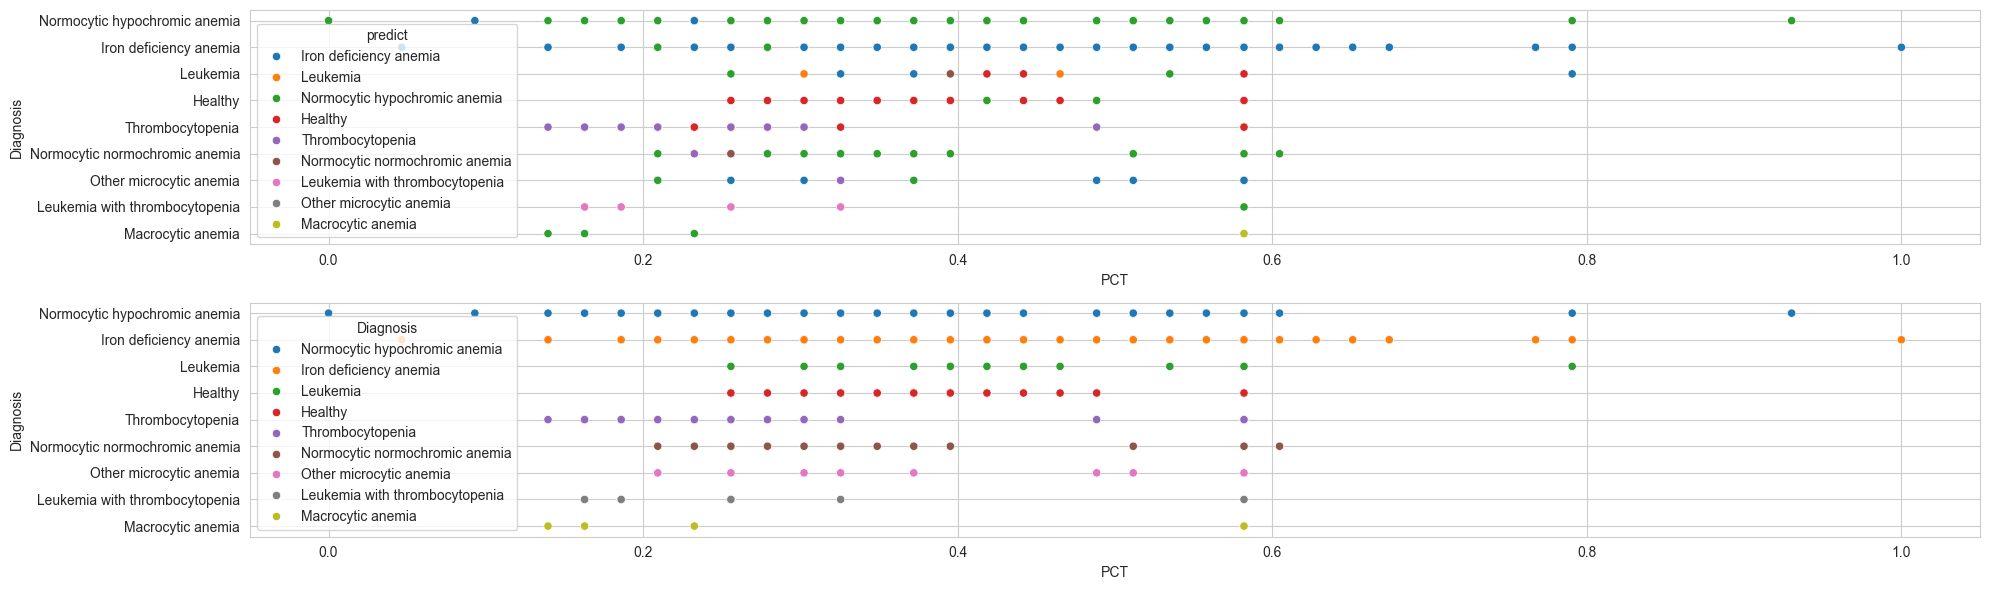

In [13]:
df_ = data.drop('Diagnosis', axis=1)

# Define x & y dataset
y = data["Diagnosis"]
x = df_.copy()

mean = x.mean(axis=0)
x = x - mean

scaler_s = StandardScaler()
scaler_m = MinMaxScaler()

x_normalized = pd.DataFrame(scaler_m.fit_transform(x), columns=x.columns)
x_standardized = pd.DataFrame(scaler_s.fit_transform(x), columns=x.columns)

x = x_normalized  # Could be change (to normalized or x)

cls = KNeighborsClassifier(n_neighbors=10)  # Could be change (1, 2, ...)
cls.fit(x, y)

labels = cls.predict(x)
x["predict"] = labels
x["Diagnosis"] = data["Diagnosis"]

accuracy = accuracy_score(y, labels)
error_rate = 1 - accuracy
print(f"Taux d'erreur: {error_rate * 100:.2f}%")

for var in x.columns[:-2]:  # iterate over columns except "predict" and "Diagnosis"
    fig, axes = plt.subplots(2, 1, figsize=(20, 6))

    # Scatter plot
    sns.scatterplot(data=x, x=var, y="Diagnosis", hue="predict", ax=axes[0])
    sns.scatterplot(data=x, x=var, y="Diagnosis", hue="Diagnosis", ax=axes[1])

    plt.tight_layout()
    plt.show()